# Assessing correctness of zod_frames_index

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_parquet("~/multimodal-MoE/outputs/index/zod256_frames.parquet")

df.shape, df.columns.tolist()


((99999, 18),
 ['frame_id',
  'time',
  'image_path',
  'scraped_weather',
  'time_of_day',
  'solar_angle_elevation',
  'country_code',
  'road_type',
  'road_condition',
  'ped_count_clear',
  'ped_count_unclear',
  'ped_occ_none',
  'ped_occ_light',
  'ped_occ_medium',
  'ped_occ_heavy',
  'ped_occ_veryheavy',
  'ped_occ_unknown',
  'ped_bin_4'])

In [ ]:
df.head()

,frame_id,time,image_path,scraped_weather,time_of_day,solar_angle_elevation,country_code,road_type,road_condition,ped_count_clear,ped_count_unclear,ped_occ_none,ped_occ_light,ped_occ_medium,ped_occ_heavy,ped_occ_veryheavy,ped_occ_unknown,ped_bin_4
0,050000,2020-05-05T05:01:50.446218Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,partly-cloudy-day,day,16.170558,SE,city,normal,1,0,1,0,0,0,0,0,1
1,050001,2020-05-28T15:54:23.333153Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,cloudy,day,27.834328,SE,city,normal,1,0,0,0,0,1,0,0,1
2,050002,2020-12-01T12:06:14.004010Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,rain,day,15.790678,DE,city,wet,1,0,1,0,0,0,0,0,1
3,050003,2020-04-14T07:24:35.996646Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,clear-day,day,28.634695,DE,city,normal,1,0,0,0,0,0,1,0,1
4,050004,2021-04-15T10:16:19.993984Z,/mnt/pr_2018_scaleout_workdir/ZOD256/single_fr...,rain,day,47.714986,PL,city,wet,5,3,0,3,0,2,0,3,1


In [ ]:
#Label distribution (excluding unclear pedestrians from the count)
df["ped_bin_4"].value_counts().sort_index()


ped_bin_4
0    42421
1    38395
2    15695
3     3488
Name: count, dtype: int64

In [9]:

df["ped_count_clear"].describe(), df["ped_count_unclear"].describe()


(count    99999.000000
 mean         3.185832
 std          5.378451
 min          0.000000
 25%          0.000000
 50%          1.000000
 75%          4.000000
 max        127.000000
 Name: ped_count_clear, dtype: float64,
 count    99999.000000
 mean         0.405954
 std          1.339227
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max         84.000000
 Name: ped_count_unclear, dtype: float64)

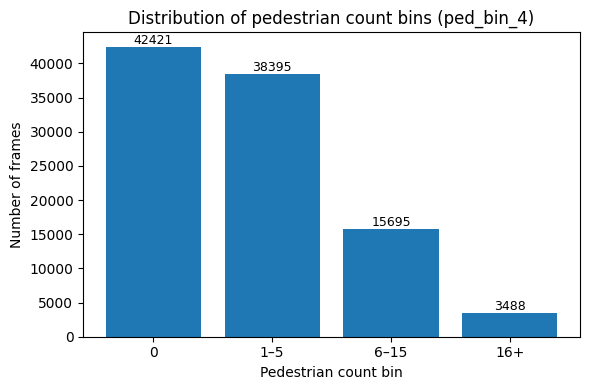

In [14]:
counts = df["ped_bin_4"].value_counts().sort_index()

plt.figure(figsize=(6,4))
bars = plt.bar(range(4), counts.values)

plt.xlabel("Pedestrian count bin")
plt.ylabel("Number of frames")
plt.title("Distribution of pedestrian count bins (ped_bin_4)")
plt.xticks(range(4), ["0", "1–5", "6–15", "16+"])

for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
